# Stroke prediction.

Information about the data:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

## Introduction:

Strokes are a significant global health concern. Annually, 15 million people worldwide suffer a stroke. Of these, 5 million die and another 5 million are left permanently disabled. In this project, we explored a supervised machine learning problem focused on stroke prediction. Using a dataset that includes various health-related features listed above.


### The difference between supervised and unsupervised machine learing problems:

* In supervised problems there is a clear target(s) to predict.
* Unsupervised problems on the other hand, don't have a target. They are just looking for patterns, structures, or relationships within the data without a clear goal.

## Importing all the libraries needed.

In [1]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score)
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import scikitplot as skplt
import warnings
import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are some object columns so we will have to encode later. That is because many algorithms need numerical input, including the ones we will be using.

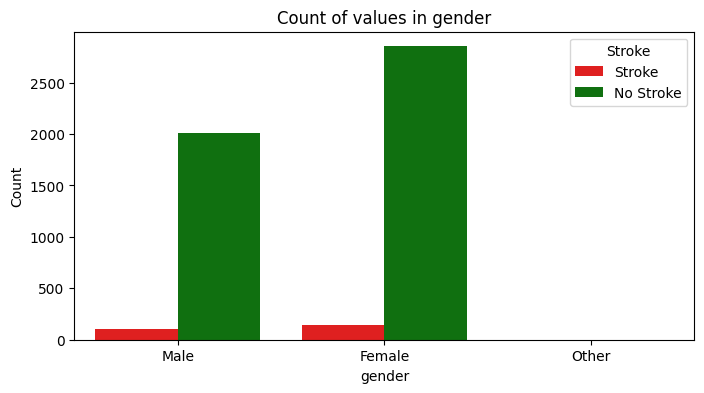

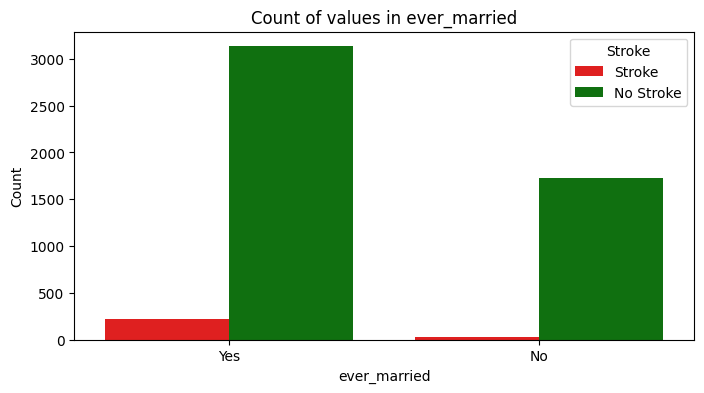

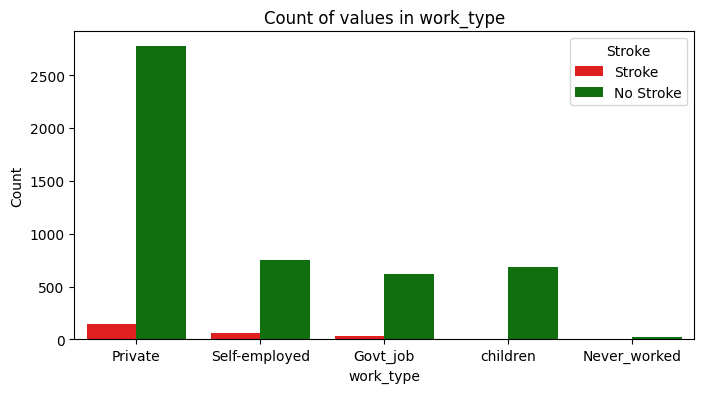

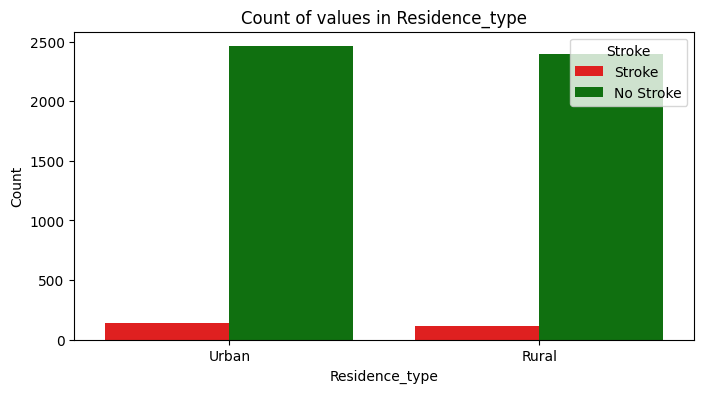

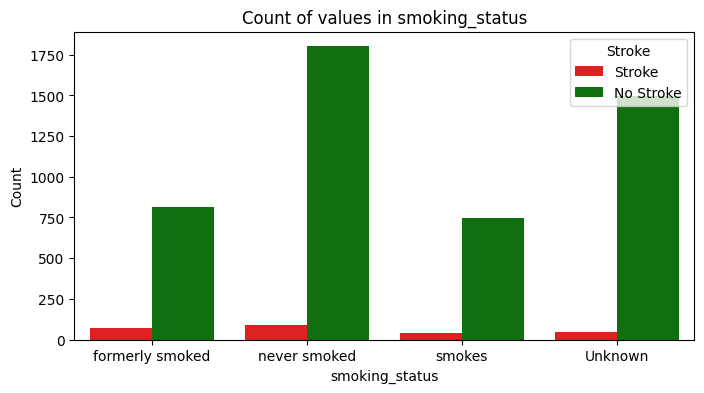

In [5]:
for column in df.columns:
    if df[column].dtype == 'object':
        plt.figure(figsize = (8, 4))
        
        df['stroke_label'] = df['stroke'].map({0: 'No Stroke', 1: 'Stroke'})
        
        sns.countplot(x = column, data = df, palette = {'No Stroke': 'green', 'Stroke': 'red'}, hue = 'stroke_label')
        plt.title(f'Count of values in {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.legend(title = 'Stroke', loc = 'upper right')
        plt.show()
df.drop('stroke_label', axis = 1, inplace = True)

While analyzing the data, I noticed that the "other" category in the Gender column consists of a singular sample. As such, I will we dropping this category due to the inability to gain any statistically insight from such a low sample size.

In [6]:
df = df[df['gender'] != 'Other']

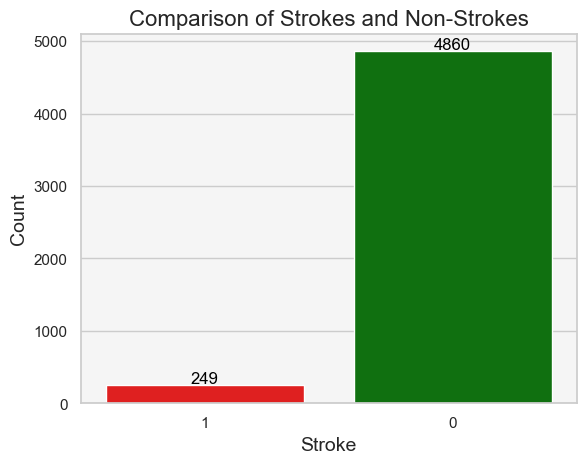

In [7]:
sns.set(style = 'whitegrid')

colors = ['#FF0000', '#008000']
sns.set_palette(sns.color_palette(colors))
ax = sns.countplot(x = 'stroke', data = df, palette = colors, order = [1, 0])

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', fontsize = 12, color = 'black', xytext = (0, 5),
                textcoords = 'offset points')

plt.title('Comparison of Strokes and Non-Strokes', fontsize=16)
plt.xlabel('Stroke', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

ax.set_facecolor('whitesmoke')

plt.show()

We can see that there is a major data imbalance. 20:1 imbalance in the 'no stroke' to 'stroke' ratio, because of the imbalance we will over sample later on.

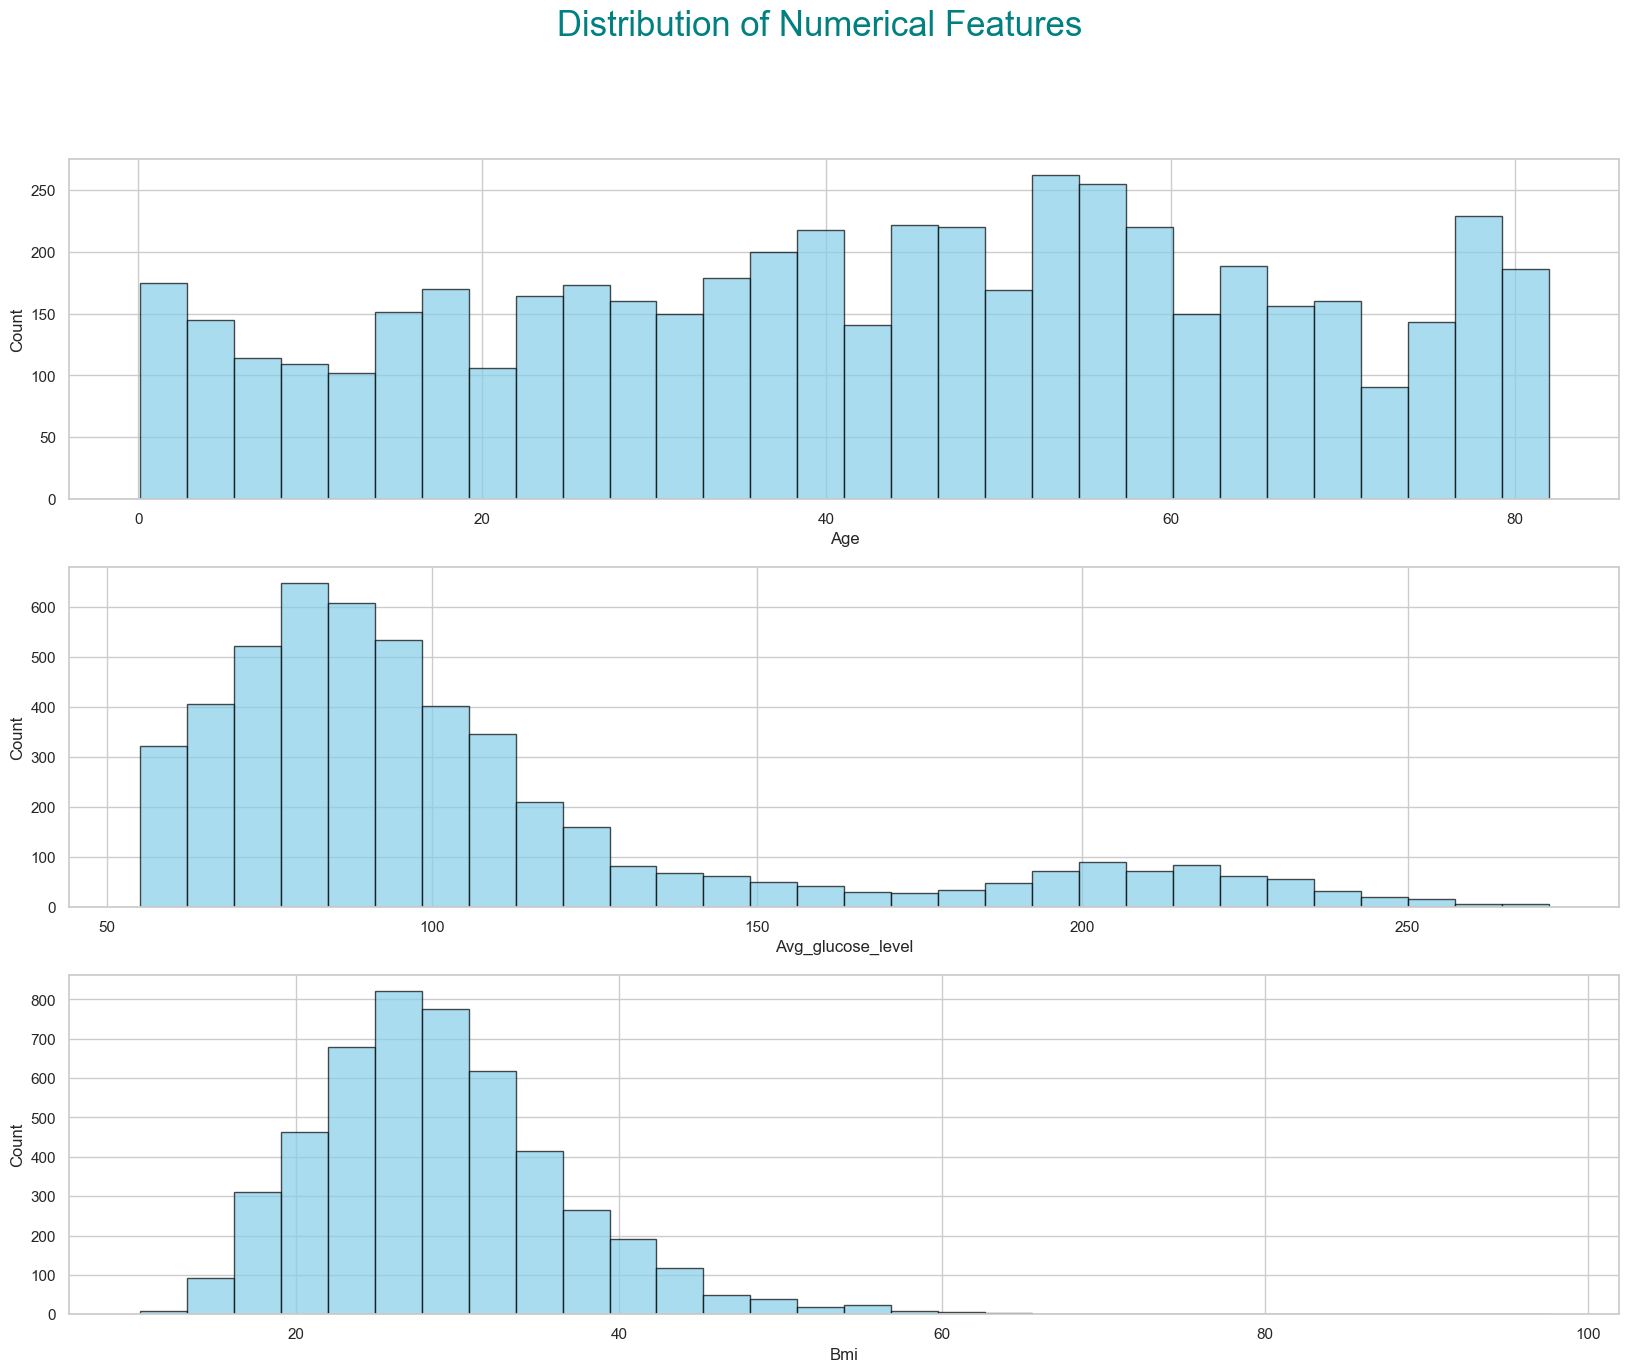

In [8]:
con_cols = ['age','avg_glucose_level','bmi']

fig, ax = plt.subplots(len(con_cols), 1, figsize = (20, 15))
fig.suptitle('Distribution of Numerical Features', fontsize = 25, color = 'teal')

for i, feature in enumerate(con_cols):
    ax[i].hist(df[feature], bins = 30, alpha = 0.7, color = 'skyblue', edgecolor = 'black')
    ax[i].set_xlabel(feature.capitalize())
    ax[i].set_ylabel('Count')
    ax[i].grid(True)

plt.show()

## Redistributing data.

Something we can see here is that avg_glucose_level and bmi are very right skewed. To deal with the outliers we will use logarithmic transformation. What that will do is compress the scale of the data, making extreme values less influential.

The reason we chose logarithm over for example square root or cube root is:
1. Log is better when data is right skewed because it is more sensative to higher numbers. meaning that it will bring down the impact of extreme values more substantially compared to square root or cube root transformations.
2. Log preserves the proportions in the lower part of the data, which would allow us to maintain the relationships among lower values. 

In [9]:
for col in ['avg_glucose_level', 'bmi']:
    df[col] = np.log(df[col])

In [10]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Handeling missing data.

Our dataset only has missing values in the BMI column. To address this, we use a Decision Tree Regressor within a pipeline to predict and impute these missing values based on other available features.

This approach is better than mean or median imputation. Because it allows for a more nuanced and context-aware  way of handling the missing data.

In [11]:
# very clever way of dealing with missing data sourced from:
# https://www.kaggle.com/code/thomaskonstantin/analyzing-and-modeling-stroke-data/notebook
bmi_imputer_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', DecisionTreeRegressor(random_state = 42))
])

features = df[['age', 'gender', 'bmi']].copy()
features['gender'] = features['gender'].map({'Male': 0, 'Female': 1}).astype(np.uint8)

missing_bmi = features[features['bmi'].isna()]
features = features[~features['bmi'].isna()]

target_bmi = features.pop('bmi')

bmi_imputer_pipeline.fit(features, target_bmi)
df.loc[missing_bmi.index, 'bmi'] = pd.Series(bmi_imputer_pipeline.predict(missing_bmi[['age', 'gender']]), index = missing_bmi.index)

In [12]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## One-Hot Encoding

We choose one-hot encoding as it works for both tree and linear models. While tree-based models can handle label-encoded data effectively, linear models often benefit from the more clear representation given by one-hot encoding.

Additionally, given the very average size of our dataset, using one-hot encoding remains practical, allowing us to enhance the interpretability and predictive power of our models without significant overhead.

In [13]:
df = pd.get_dummies(df, columns = df.select_dtypes(include = ['object']).columns, drop_first = True)
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,5.432367,3.600048,1,1,1,0,1,0,0,1,1,0,0
1,51676,61.0,0,0,5.309307,3.361757,1,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,4.662684,3.481240,1,1,1,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,5.143008,3.538057,1,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,1,0,5.159745,3.178054,1,0,1,0,0,1,0,0,0,1,0


## Oversampling.

For oversampling we use RandomOverSampler to even out the class imbalance. It does this by replicating instances of the minority class until the classes are balanced.

### Why We Chose Oversampling Over smote:

While both oversampling and smote fix class imbalance, we chose  for oversampling in this case for simplicity and efficiency. Smote makes synthetic samples rather than replicating existing ones. In scenarios where the dataset is nog large or the minority class is very small, smote might cause noise or overfitting.

In [14]:
oversample = RandomOverSampler(sampling_strategy='minority')
X = df.drop(['stroke'],axis = 1)
y = df['stroke']
X_over, y_over = oversample.fit_resample(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, stratify = y_over, random_state = 42)

## Standardizing the data.

Standardizing the data is a scaling technique that transforms the features of a dataset to have a mean of 0 and a standard deviation of 1. What that means is that the algorithm will treat features equaly no matter the magnitudes.


###  Why standardization over normalization.

We choose standardization because some algorithms rely on the assumption of a Gaussian distribution (bell-shaped curve) in the features. For example Linear Regression, Logistic Regression and svm.


the formula for standardization: Z = (X – μ) / σ

Where:
- Z is the standardized value.
- X is the original value of the feature.
- μ is the mean of the feature.
- σ is the standard deviation of the feature.



the formula for normalization: X-norm = (X - min(X)) / (max(X) - min(X))



In [16]:
scaler = StandardScaler()

X_train[con_cols] = scaler.fit_transform(X_train[con_cols])
X_test[con_cols] = scaler.transform(X_test[con_cols])

In [17]:
models = {
    'Logistic regression':LogisticRegression(),
    'Tree':DecisionTreeClassifier(),
    'random Forest':RandomForestClassifier(),
    'xg':xgb.XGBClassifier(),
    'knn':KNeighborsClassifier(),
    'svm': SVC(probability = True)
} 
f1scores = []

In [18]:
for name,model in models.items():
    model.fit(X_train,y_train)
    p = model.predict(X_train)  
    y_pred = model.predict(X_test)
    y_pred_prob_st = model.predict_proba(X_test)[:, 1]
    print('Model: ', name)
    print('---------------------------------------------------')    
    print(classification_report(y_test,y_pred))
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_st))
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('.....................................................|')

    f1 = f1_score(y_test, y_pred)
    f1scores.append((name, f1))

Model:  Logistic regression
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1458
           1       0.50      1.00      0.67      1458

    accuracy                           0.50      2916
   macro avg       0.25      0.50      0.33      2916
weighted avg       0.25      0.50      0.33      2916

ROC AUC Score: 0.4976963576389477
Accuracy: 0.5
.....................................................|
Model:  Tree
---------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1458
           1       0.95      1.00      0.98      1458

    accuracy                           0.98      2916
   macro avg       0.98      0.98      0.98      2916
weighted avg       0.98      0.98      0.98      2916

ROC AUC Score: 0.97599451303155
Accuracy: 0.97599451303155
.......................................

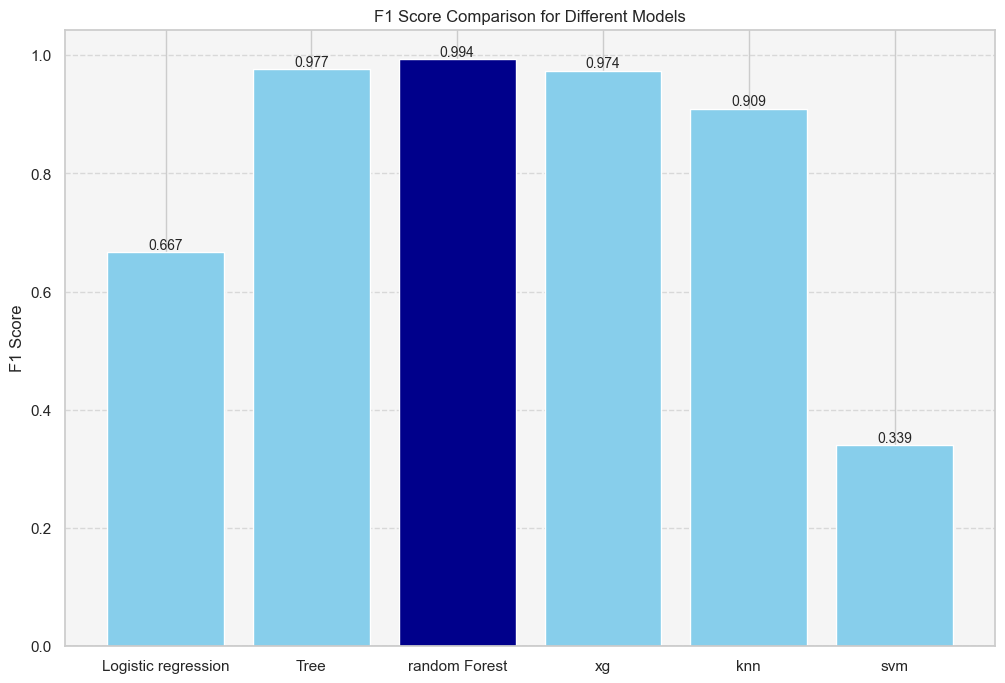

In [19]:
model_names, f1_scores = zip(*f1scores)

f1_scores = [float(score) for score in f1_scores]

fig, ax = plt.subplots(figsize = (12, 8))

ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '-', alpha = 0.5)

original_colors = ['skyblue' if score != max(f1_scores) else 'darkblue' for score in f1_scores]

bars = ax.bar(model_names, f1_scores, color = original_colors)

for bar, value in zip(bars, f1_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha = 'center', va = 'bottom', fontsize = 10)

plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Different Models')

ax.set_facecolor('#f5f5f5')

ax.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.show()

## Optimizing Hyperparameters with Optuna.

### What is Optuna?

Optuna is a hyperparameter optimization framework that operates on the principle of intelligent search. Instead of exhaustively trying every possible combination of hyperparameter values, Optuna uses a smart strategy to explore the hyperparameter space more efficiently.


### How it works.

1. Define the Objective Function: We start by defining an objective function that evaluates the performance of our model based on a given set of hyperparameters. Optuna's task is to find the hyperparameters that maximize or minimize this objective function.

2. Set the Hyperparameter Search Space: We specify the range or possible values for each hyperparameter. Optuna samples values from this search space during its optimization process.

3. Trial and Error with Bayesian Optimization: Optuna uses Bayesian optimization, a probability based technique. It starts with a few initial trials, evaluates the objective function and then uses this information to decide where to sample the next set of hyperparameters.

## Evaluation Matrixes
1. **Classification Report:**
   - *Purpose:* The classification report provides a good summary of the model's performance for each class. It includes precision, recall, and F1-score, which are crucial metrics for understanding how well the model is distinguishing between classes. It's particularly valuable in scenarios with imbalanced classes because it shows accuracy for both true and false senarios.
2. **Accuracy:**
   - *Purpose:* Accuracy represents the proportion of correctly predicted instances among the total instances. While it is a commonly used metric, it isnt the best for imbalanced datasets. Nevertheless, it provides a general overview of the model's overall correctness.
3. **ROC AUC Score:**
   - *Purpose:* The Receiver Operating Characteristic Area Under the Curve (ROC AUC) score is essential for binary and multiclass classification problems. It evaluates the model's ability to separate between classes across different probability thresholds. A higher ROC AUC score indicates better separation.
4. **Confusion Matrix:**
   - *Purpose:* The confusion matrix provides a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives. It is the foundation for deriving other metrics like precision, recall, and specificity. The visualization of the confusion matrix aids in understanding the types of errors the model is making.

In [20]:
def full_report(optimal_model):
    y_pred = optimal_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(classification_report(y_test,y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize = (6, 6), cmap = 'YlGnBu');

In [21]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
    }

    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 40)
print('done searching')

done searching


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1458
           1       0.98      1.00      0.99      1458

    accuracy                           0.99      2916
   macro avg       0.99      0.99      0.99      2916
weighted avg       0.99      0.99      0.99      2916

Accuracy: 0.9897119341563786
ROC AUC Score: 0.9897119341563786


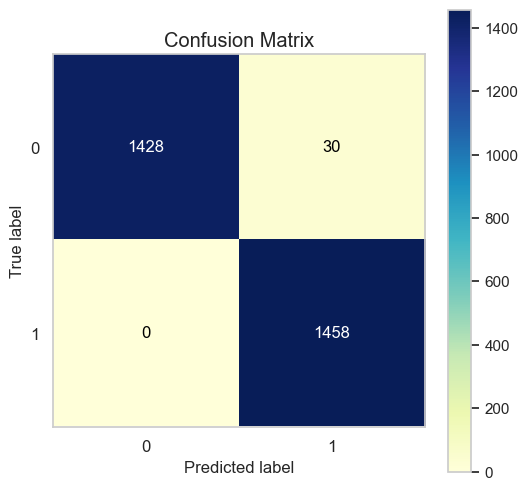

In [23]:
best_params = study.best_params
optimal_rf_model = RandomForestClassifier(**best_params)
optimal_rf_model.fit(X_train, y_train)

full_report(optimal_rf_model)

## Worse performace after tuning hyperparameters.
We can see that random forest performed slightly worse after hyperparameter tuning even after 40 trails.
This could be due to slight overfitting, but random forest is a robust model that often performs well with default parameters. which means it isnt very sensative to hyperparameter tuning.

## Svm hyperparameters.
Svm was super low and is very sensative to parametrs so big chance that the default parameters just werent a good fit with this dataset.

In [24]:
def objective(trial):
    params = {
        'C': trial.suggest_int('C', 0.01, 1000),
        'gamma': trial.suggest_int('gamma', 0.1, 1000)
    }

    optimal_svm_model = SVC(**params)
    optimal_svm_model.fit(X_train, y_train)
    
    y_pred = optimal_svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [25]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)
print('done searching')

done searching


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1458
           1       1.00      1.00      1.00      1458

    accuracy                           1.00      2916
   macro avg       1.00      1.00      1.00      2916
weighted avg       1.00      1.00      1.00      2916

Accuracy: 1.0
ROC AUC Score: 1.0


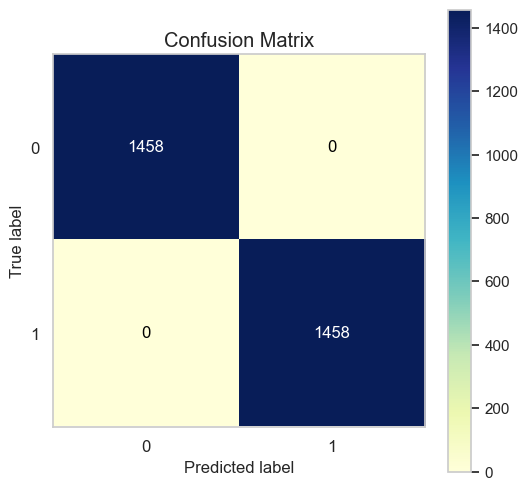

In [26]:
best_params = study.best_params
optimal_svm_model = SVC(**best_params)
optimal_svm_model.fit(X_train, y_train)

full_report(optimal_svm_model)

## Svm performance.
Svm showed great performance even after only 10 trails. This can happen because not only is svm sentative to tuning. It is extra sensative when using non-liniar kernals, such as the default radial basis function (RBF).

## Conclusion:
In summary, our analysis of the stroke prediction dataset revealed challenges with significant class imbalance. We addressed this using oversampling and implemented various preprocessing steps. Among the models tested, Support Vector Machines (SVM) performed the best after hyperparameter tuning. Even with Random Forest's robustness, it showed a slight decrease in performance after tuning.

The project showed the sensitivity of SVMs to hyperparameter tuning, particularly with non-linear kernels. Optuna proved effective in optimizing SVM hyperparameters. The final SVM model, with tuned parameters, demonstrated strong predictive performance for stroke prediction and was the best choice.